# Contexto del Problema

 Es vital para las compañías ser capaces de identificar transacciones fraudulentas con alta precisión. El objetivo principal es garantizar la seguridad de los clientes, evitando que se les cobre por compras que no realizaron, protegiendo así su patrimonio y la confianza en el sistema.

# Objetivos
1. Exploración de Datos (EDA): Analizar la distribución de las transacciones y visualizar el desbalance extremo entre clases.
2. Preprocesamiento: Escalar variables (Time/Amount) y aplicar técnicas de SMOTE para equilibrar el conjunto de datos y evitar el sesgo hacia la clase mayoritaria.
3. Modelado: Entrenar y comparar algoritmos de clasificación (Regresión Logística vs. Random Forest).
4. Evaluación: Utilizar métricas adecuadas para evaluar el rendimiento de los modelos.
 

In [44]:
import pandas as pd

path = "../data/creditcard.csv"

df = pd.read_csv(path)

print(df.head(3))
print("=" * 60)
print(df.isnull().sum())
print("=" * 60)
print(df.shape)




   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  

[3 rows x 31 columns]
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11

Conteo de valores de Class
Class
0    284315
1       492
Name: count, dtype: int64


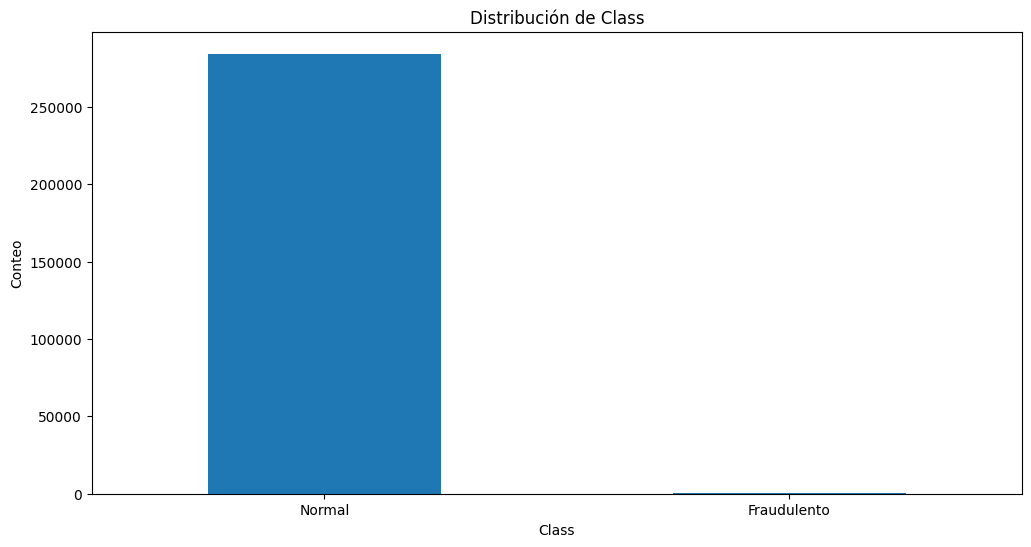

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print("Conteo de valores de Class")
print(df["Class"].value_counts())
print("=" * 60)
fig, ax = plt.subplots(figsize=(12, 6))
df["Class"].value_counts().plot(kind="bar", ax=ax)
ax.set_title("Distribución de Class")
ax.set_xticklabels(["Normal", "Fraudulento"], rotation=0)
ax.set_xlabel("Class")
ax.set_ylabel("Conteo")
plt.show()

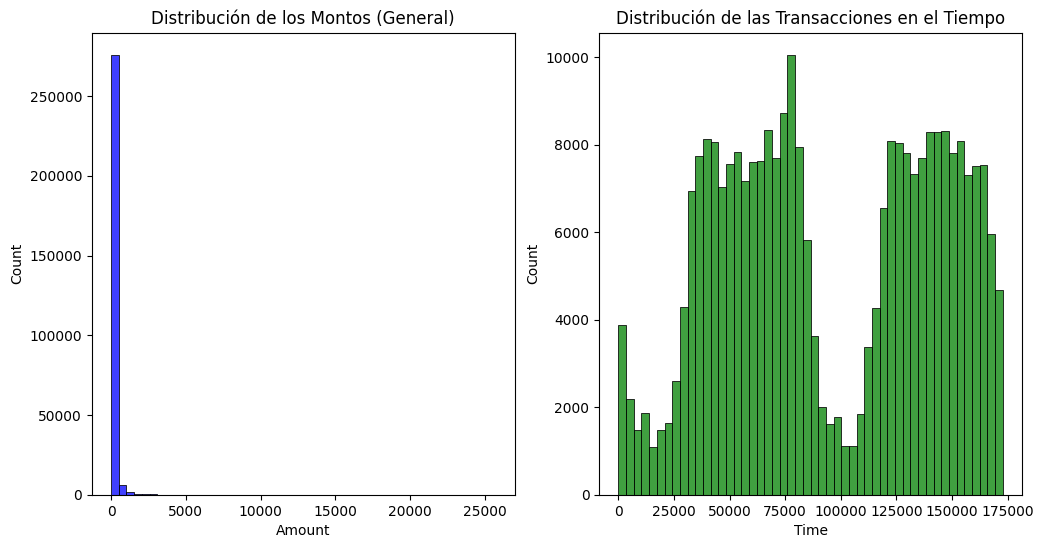

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(df["Amount"], ax=ax[0], color="blue", bins=50)
ax[0].set_title("Distribución de los Montos (General)")

sns.histplot(df["Time"], ax=ax[1], color="green", bins=50)
ax[1].set_title("Distribución de las Transacciones en el Tiempo")

plt.show()

--- Nuevo Conteo de Clases ---
Class
1    492
0    492
Name: count, dtype: int64


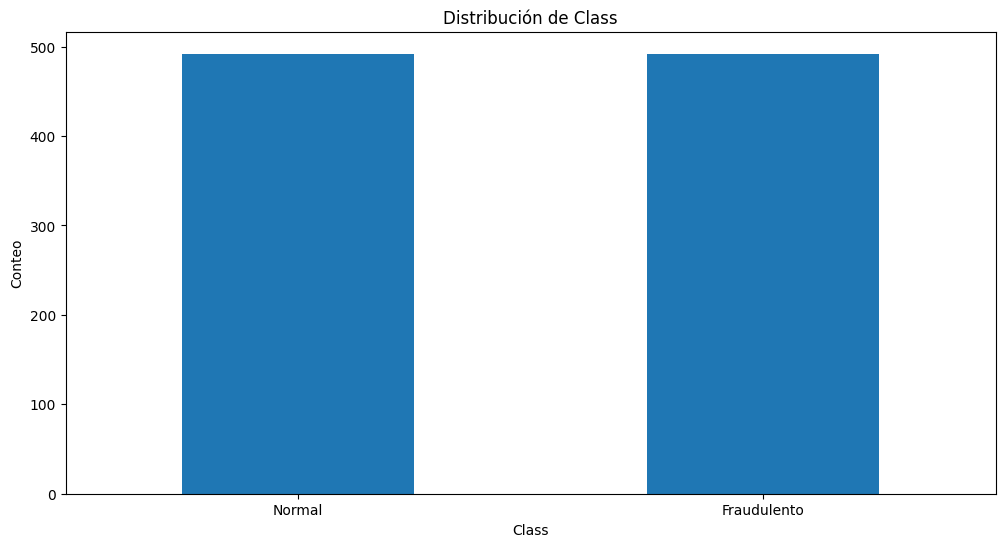

In [41]:
# Se toman la misma cantidad de NO fraudes que fraudes (YA QUE HAY MUCHA DIFERENCIA)

fraud_df = df[df['Class'] == 1]
normal_df = df[df['Class'] == 0]

normal_sample = normal_df.sample(n=492, random_state=42)

new_df = pd.concat([fraud_df, normal_sample], axis=0)

print("--- Nuevo Conteo de Clases ---")
print(new_df['Class'].value_counts())

print("=" * 60)
fig, ax = plt.subplots(figsize=(12, 6))
new_df["Class"].value_counts().plot(kind="bar", ax=ax)
ax.set_title("Distribución de Class")
ax.set_xticklabels(["Normal", "Fraudulento"], rotation=0)
ax.set_xlabel("Class")
ax.set_ylabel("Conteo")
plt.show()

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = new_df.drop("Class", axis=1)
y= new_df["Class"]

X = StandardScaler().fit_transform(X)

# Se divide el conjunto (PRUEBA Y ENTRENAMIENTO)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape)
print(y_train.shape)

(688, 30)
(688,)


In [46]:
# MODELO DE REGRESION LOGISTICA

from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(solver='lbfgs')

logistic.fit(X_train, y_train)

print("SCORE: ", logistic.score(X_test, y_test))

SCORE:  0.9358108108108109


In [13]:
# REPORTE DE MODELO

from sklearn.metrics import classification_report

y_pred = logistic.predict(X_test)


print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94       146
           1       0.99      0.88      0.93       150

    accuracy                           0.94       296
   macro avg       0.94      0.94      0.94       296
weighted avg       0.94      0.94      0.94       296



El AUC Score de tu Regresión Logística es: 0.9836


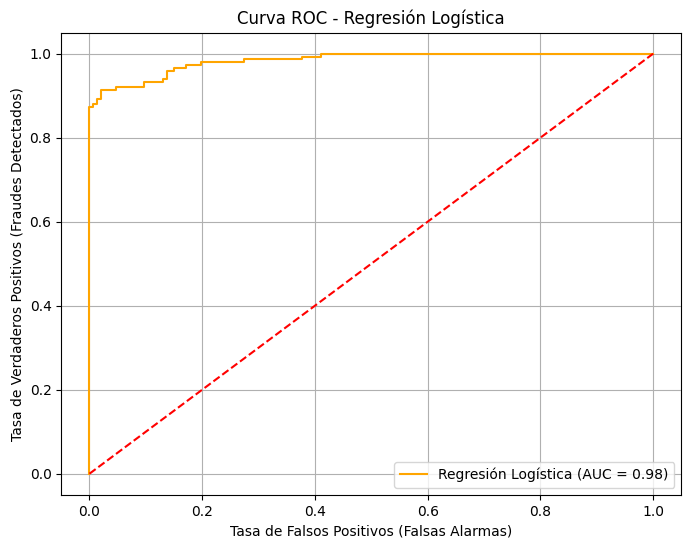

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 1. OBTENER PROBABILIDADES
# OJO: Aquí uso 'model' asumiendo que así llamaste a tu regresión logística. 
# Si le pusiste 'log_reg' u otro nombre, cámbialo aquí abajo.
y_probs_lr = logistic.predict_proba(X_test)[:, 1]

# 2. CALCULAR EL SCORE AUC
auc_lr = roc_auc_score(y_test, y_probs_lr)
print(f"El AUC Score de tu Regresión Logística es: {auc_lr:.4f}")

# 3. GRAFICAR
fpr, tpr, thresholds = roc_curve(y_test, y_probs_lr)

plt.figure(figsize=(8, 6))
# Usamos color naranja para diferenciarlo del azul que usaremos en Random Forest
plt.plot(fpr, tpr, color='orange', label=f'Regresión Logística (AUC = {auc_lr:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--') # Línea de "suerte"
plt.xlabel('Tasa de Falsos Positivos (Falsas Alarmas)')
plt.ylabel('Tasa de Verdaderos Positivos (Fraudes Detectados)')
plt.title('Curva ROC - Regresión Logística')
plt.legend()
plt.grid()
plt.show()

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

# 4. Ver el reporte
print("--- Reporte de Random Forest ---")
print(classification_report(y_test, y_pred_rf))

--- Reporte de Random Forest ---
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       146
           1       0.99      0.88      0.93       150

    accuracy                           0.94       296
   macro avg       0.94      0.94      0.94       296
weighted avg       0.94      0.94      0.94       296



In [16]:
# SE APLICA SMOTE PARA CREAR DATOS SINTETICOS (PARECIDOS A LOS ORIGINALES)

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler

X = df.drop("Class", axis=1)
y= df["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = RobustScaler()

X_train[['Amount', 'Time']] = scaler.fit_transform(X_train[['Amount', 'Time']])
X_test[['Amount', 'Time']] = scaler.fit_transform(X_test[['Amount', 'Time']])

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("=" * 60)
print(f"Antes de SMOTE: {y_train.value_counts()}")
print(f"Después de SMOTE: {y_train_resampled.value_counts()}")

rf_model_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_smote.fit(X_train_resampled, y_train_resampled)

y_pred_smote = rf_model_smote.predict(X_test)

print("=" * 60)
print("REPORTE FINAL CON SMOTE")
print(classification_report(y_test, y_pred_smote))

Antes de SMOTE: Class
0    199008
1       356
Name: count, dtype: int64
Después de SMOTE: Class
0    199008
1    199008
Name: count, dtype: int64
REPORTE FINAL CON SMOTE
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.86      0.88      0.87       136

    accuracy                           1.00     85443
   macro avg       0.93      0.94      0.93     85443
weighted avg       1.00      1.00      1.00     85443



AUC Score: 0.9808


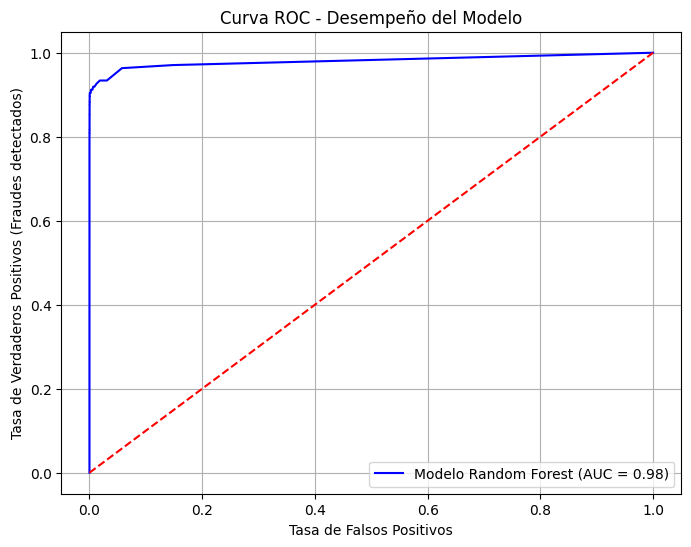

In [17]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 1. Obtenemos las probabilidades (qué tan seguro está el modelo)
y_probs = rf_model_smote.predict_proba(X_test)[:, 1]

# 2. Calculamos el puntaje AUC
auc_score = roc_auc_score(y_test, y_probs)
print(f"AUC Score: {auc_score:.4f}")

# 3. Graficamos la Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'Modelo Random Forest (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--') # Línea de "suerte" (50/50)
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos (Fraudes detectados)')
plt.title('Curva ROC - Desempeño del Modelo')
plt.legend()
plt.grid()
plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_16896\1280986617.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')


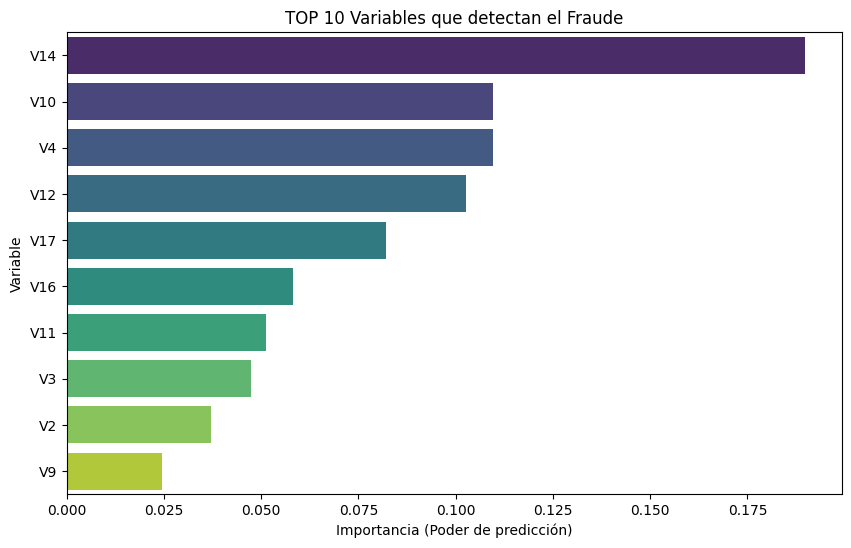

Las 3 variables con mayor importancia/relevancia:
   Feature  Importance
14     V14    0.189692
10     V10    0.109707
4       V4    0.109658


In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Extraemos la importancia de cada columna (viene dentro del modelo entrenado)
importancias = rf_model_smote.feature_importances_
nombres_columnas = X.columns

# 2. Creamos un DataFrame para ordenarlos
feature_importance_df = pd.DataFrame({
    'Feature': nombres_columnas,
    'Importance': importancias
}).sort_values(by='Importance', ascending=False)

# 3. Graficamos el Top 10 de "Delatores"
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
plt.title('TOP 10 Variables que detectan el Fraude')
plt.xlabel('Importancia (Poder de predicción)')
plt.ylabel('Variable')
plt.show()

print("Las 3 variables con mayor importancia/relevancia:")
print(feature_importance_df.head(3))